### Import Libraries

In [1]:
from math import sqrt
import pandas as pd
import numpy as np
import warnings
import time
import re
warnings.filterwarnings("ignore")

from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression, BayesianRidge, Lasso, Ridge
from sklearn.preprocessing import PolynomialFeatures, LabelEncoder
from sklearn.feature_selection import SelectKBest, SelectFwe
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import Pipeline
from sklearn import preprocessing
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
from sklearn.svm import SVR

### Measure function

This function contains the most important measures to evaluate a regression model. 

In [2]:
def executeModel(model, features_used=False, error=False):
    model.fit(features_train,rating_train)
    y_pred = model.predict(features_test)
    
    scores = cross_val_score(model,features_train,rating_train,cv=10)
    
    if(features_used):
        coeff_used = np.sum(model.coef_!=0)
        print("Number of features used: ", coeff_used)
    
    if(error):
        print("Loss: ", model.loss_)
    
    print("Score (Average): ", scores.mean())
    print("Score (Minimum): ", scores.min())
    print("MAE: ", mean_absolute_error(rating_test, y_pred))
    print("MSE: ", mean_squared_error(rating_test, y_pred))
    print("RMSE: ", sqrt(mean_squared_error(rating_test, y_pred)))
    print("R^2: ", r2_score(rating_test,y_pred))

## 1. Import Data from Preprocessing

In [3]:
df_joined = pd.read_csv("regressionPreprocessingGeneral.csv")
df_joined = df_joined.fillna(0)
print("Length after import: " + str(len(df_joined)))
print("Features after import: " + str(len(df_joined.columns)))

Length after import: 43872
Features after import: 66


### Remove Features (if needed)

In [4]:
features_to_remove = ['movieId','id','18+','actors','productionCompanies','productionCountries','imdbId','spokenLanguages','budget_norm','runtime_norm']
for i in features_to_remove:
    if i in df_joined.columns:
        df_joined = df_joined.drop(columns=i)
print("Features: ", len(df_joined.columns))
df_joined.head(5)

Features:  60


,budget,runtime,Documentary,Foreign,Action,Horror,War,Romance,Adventure,Thriller,...,actor_John Wayne,actor_Donald Sutherland,actor_Robert De Niro,actor_Samuel L. Jackson,actor_Jackie Chan,actor_Michael Caine,actor_Christopher Lee,actor_Frank Welker,actor_John Carradine,actor_Gérard Depardieu
0,30000000,81.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
1,65000000,104.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0,0,0,0,0,0,0,0,0,0
2,0,101.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
3,16000000,127.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
4,0,106.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0


### Encode Director

In [5]:
lab_enc = LabelEncoder()
df_joined["director"] = df_joined["director"].astype(str)
df_joined["director"] = lab_enc.fit_transform(df_joined["director"])
df_joined.director.head(3)

0    10846
1    10608
2     9347
Name: director, dtype: int32

### Train and Test Split (needed for Feature Selection)

The algorithms used for feature selection need the data separated in train and test data.

In [6]:
df_joined_copy = df_joined.copy()
rating = df_joined['rating']

features = df_joined_copy.drop(columns=['rating'])
features_train, features_test, rating_train, rating_test = train_test_split(
    features, rating, test_size=0.3, random_state=42)

print("Train: " + str(len(features_train)) + " Feature Entries and " + str(len(rating_train)) + " Ratings")
print("Test: " + str(len(features_test)) + " Features Entries and " + str(len(rating_test)) + " Ratings")

Train: 35097 Feature Entries and 35097 Ratings
Test: 8775 Features Entries and 8775 Ratings


## 2. Feature Selection

### 2.1. XGBoost Regressor

In [7]:
regressor = XGBRegressor(colsample_bytree= 0.6, gamma= 0.7, max_depth= 4, min_child_weight= 5,
                         subsample = 0.8, objective='reg:squarederror')
regressor.fit(features_train, rating_train)

bestFeaturesXGB = []
importances = {}

count = 0
for feature_importance in regressor.feature_importances_:
    if feature_importance > 0.01:
        feature_name = features_train.columns[count]
        importances[feature_name] = feature_importance
    count+=1

for key, value in sorted(importances.items(), key=lambda item: item[1], reverse=True):
    #print("%s: %s" % (key, value))
    if key not in bestFeaturesXGB:
        bestFeaturesXGB.append(key)

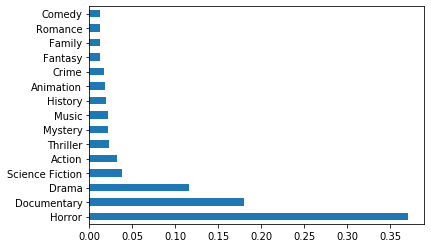

In [8]:
feat_importances = pd.Series(regressor.feature_importances_, index=features_train.columns)
feat_importances.nlargest(15).plot(kind='barh')
plt.show()

### 2.2. F Regression

In [9]:
reg = LinearRegression()
reg.fit(features_train, rating_train)
mse = mean_squared_error(rating_test, reg.predict(features_test))
print("RMSE:", sqrt(mse))

RMSE: 0.6951549694510253


In [10]:
from sklearn.feature_selection import f_regression

# run the F-Test
f, pval = f_regression(features_train, rating_train)

# prepare a dataframe to inspect the results
stat = pd.DataFrame({ 'feature': features_train.columns, 'F value': f, 'p value': pval })
stat['p value'] = round(stat['p value'], 2)
stat = stat.sort_values("p value", ascending=False)[:10]
# show the results
display(stat)

,feature,F value,p value
3,Foreign,0.969504,0.32
25,director,1.057778,0.30
24,hasHomepage,1.105561,0.29
22,part_of_collection,1.201632,0.27
16,Western,1.282254,0.26
15,Crime,2.416716,0.12
14,TV Movie,2.435959,0.12
13,Comedy,2.827390,0.09
17,Mystery,2.847389,0.09
19,Animation,6.103974,0.01


In [11]:
best = SelectFwe(f_regression, alpha=0.05)

estimator = LinearRegression()
pipeline = Pipeline([ ('feature_selection', best), ('estimator', estimator)])

# fit the regression on the training data
pipeline.fit(features_train, rating_train)

# predict the values for the test data
predictions = pipeline.predict(features_test)

# evaluate on the test set
rmse = sqrt(mean_squared_error(rating_test, predictions))
print("RMSE:", rmse)

RMSE: 0.6969192928600361


In [12]:
features_train_selected = best.fit_transform(features_train, rating_train)

# run the F-Test
f, pval = f_regression(features_train_selected, rating_train)

# prepare a dataframe to inspect the results
new_feature_names = [feature_name for (is_used, feature_name) in zip(best.get_support(), features_train.columns) if is_used]

stat = pd.DataFrame({ 'feature': new_feature_names, 'F value': f, 'p value': pval })
stat['p value'] = round(stat['p value'], 2)
stat = stat.sort_values("p value", ascending=False)
# show the results
display(stat)

bestFeaturesFRegression = new_feature_names

,feature,F value,p value
0,budget,19.653729,0.0
1,runtime,20.675263,0.0
2,Documentary,744.620074,0.0
3,Action,279.817428,0.0
4,Horror,1958.668656,0.0
5,War,54.404249,0.0
6,Romance,77.127847,0.0
7,Adventure,49.557970,0.0
8,Thriller,282.382418,0.0
9,History,159.794801,0.0


### 2.3. Select K Best

In [13]:
from sklearn.feature_selection import SelectKBest, mutual_info_regression, f_regression

bestFeaturesKBest = []

selector = SelectKBest(f_regression, k=10)
fit = selector.fit(features_train,rating_train)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(features_train.columns)
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Features','Score']
print("## F-Regression: ")
print(featureScores.nlargest(15,'Score'))
for index,row in featureScores.sort_values('Score',ascending=False)[:10].iterrows():
    if row.Features not in bestFeaturesKBest:
        bestFeaturesKBest.append(row.Features)

print("\nBest Features from K-Best: ", bestFeaturesKBest)

## F-Regression: 
           Features        Score
5            Horror  1958.668656
11            Drama   854.546852
2       Documentary   744.620074
21  Science Fiction   459.813314
9          Thriller   282.382418
4            Action   279.817428
10          History   159.794801
7           Romance    77.127847
20            Music    67.632877
6               War    54.404249
8         Adventure    49.557970
1           runtime    20.675263
0            budget    19.653729
18          Fantasy    10.953889
12           Family     8.380830

Best Features from K-Best:  ['Horror', 'Drama', 'Documentary', 'Science Fiction', 'Thriller', 'Action', 'History', 'Romance', 'Music', 'War']


### 2.4. Merge Results

In [14]:
# XGB Regressor --> bestFeaturesXGB
# F-Regression with PolynomialFeatures --> bestFeaturesFRegression
# Select K Best --> bestFeaturesKBest
print(len(bestFeaturesXGB))
print(len(bestFeaturesFRegression))
print(len(bestFeaturesKBest))

bestFeatures = list(set().union(bestFeaturesXGB, bestFeaturesFRegression, bestFeaturesKBest))
print("Nr of selected features: ",len(bestFeatures))
print("Best features: ",bestFeatures)

18
13
10
Nr of selected features:  20
Best features:  ['runtime', 'Documentary', 'Science Fiction', 'Thriller', 'Crime', 'History', 'Romance', 'Horror', 'Mystery', 'Family', 'Animation', 'Music', 'War', 'budget', 'Adventure', 'Action', 'Drama', 'Fantasy', 'Comedy', 'part_of_collection']


### 2.5. Remove features, which are not relevant

In [15]:
rating = df_joined['rating']

for i in df_joined.columns:
    if i not in bestFeatures:
        df_joined = df_joined.drop(columns=i)

print("Selected features: ", len(df_joined.columns))
df_joined.head(5)

Selected features:  20


,budget,runtime,Documentary,Action,Horror,War,Romance,Adventure,Thriller,History,Drama,Family,Comedy,Crime,Mystery,Fantasy,Animation,Music,Science Fiction,part_of_collection
0,30000000,81.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1
1,65000000,104.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0
2,0,101.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,16000000,127.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,0,106.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1


### 2.6. Correlation Analysis

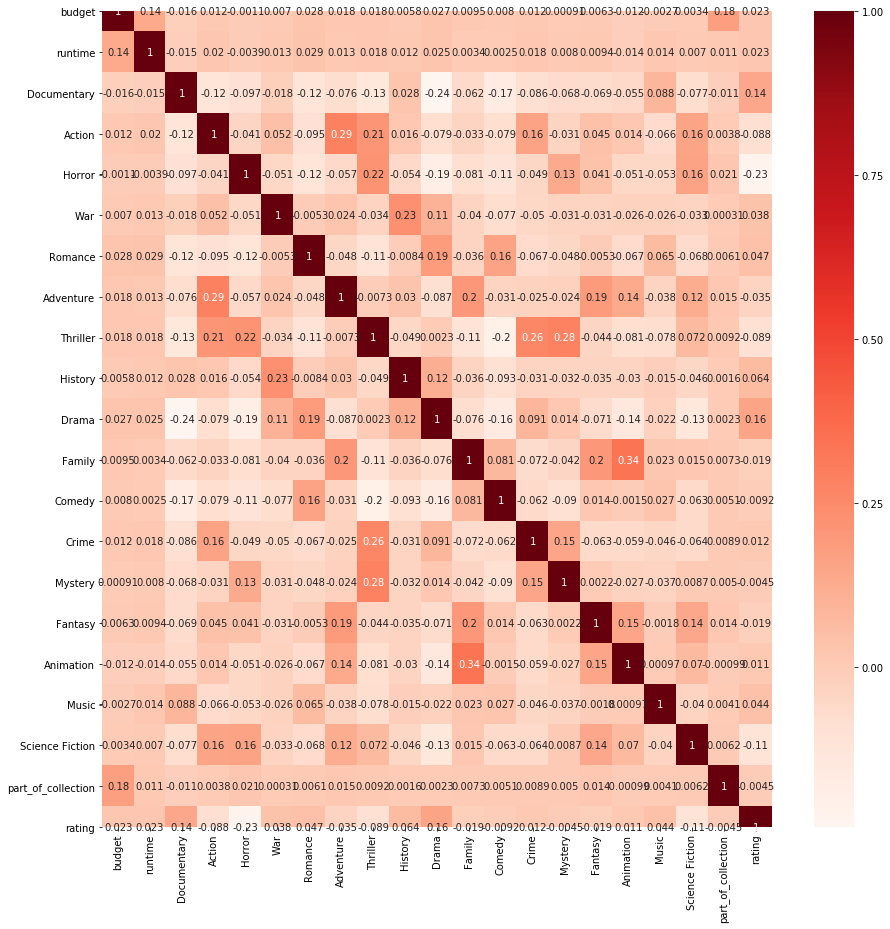

In [16]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# Pearson Correlation (0 no correlation, 1 stronger positive correlation, -1 stronger negative correlation)
plt.figure(figsize=(15,15))
df_joined['rating'] = rating
cor = df_joined.corr()
sns.heatmap(cor, annot=True, cmap = plt.cm.Reds)
plt.show()

As we can see Horror has the most negative influence on rating

## 3. Split again only with selected attributes

In [17]:
features = preprocessing.scale(df_joined)
#features = df_joined

# create a train/test split
features_train, features_test, rating_train, rating_test = train_test_split(
    features, rating, test_size=0.3, random_state=42)

print("Train: " + str(len(features_train)) + " Feature Entries and " + str(len(rating_train)) + " Ratings")
print("Test: " + str(len(features_test)) + " Features Entries and " + str(len(rating_test)) + " Ratings")

Train: 30710 Feature Entries and 30710 Ratings
Test: 13162 Features Entries and 13162 Ratings


## 4. First run (trying all algorithms with default parameters)

In [18]:
print("### Linear Regression ###")
model = LinearRegression()
executeModel(model)

print("\n### Ridge ###")
model = Ridge()
executeModel(model)

print("\n### Bayesian Ridge ###")
model = BayesianRidge()
executeModel(model)

print("\n### Lasso ###")
model = Lasso()
executeModel(model, features_used=True)

print("\n### Ada Boost Regressor ###")
model = AdaBoostRegressor(DecisionTreeRegressor())
executeModel(model)

print("\n### Ada Boost Regressor (different values) ###")
ada_tree_backing = DecisionTreeRegressor(max_features='sqrt', splitter='random', min_samples_split=4, max_depth=3)
model = AdaBoostRegressor(ada_tree_backing, learning_rate=0.1, loss='square', n_estimators=1000)
executeModel(model)

#print("\n### SVR ###")
#model = SVR()
#executeModel(model)

print("\n### K-Neighbors Regressor ###")
model = KNeighborsRegressor()
executeModel(model)

print("\n### Random Forest Regressor ###")
model = RandomForestRegressor()
executeModel(model)

print("\n### Random Forest Regressor (different values) ###")
model = RandomForestRegressor(max_features=2, min_samples_split=4, n_estimators=50, min_samples_leaf=2)
executeModel(model)

print("\n### Gradient Boosting Regressor ###")
model = GradientBoostingRegressor()
executeModel(model)

print("\n### Gradient Boosting Regressor (different values) ###")
model = GradientBoostingRegressor(loss='quantile', learning_rate=0.0001, n_estimators=50, max_features='log2', min_samples_split=2, max_depth=1)
executeModel(model)

### Linear Regression ###
Score (Average):  1.0
Score (Minimum):  1.0
MAE:  4.991701728557022e-16
MSE:  4.810473740103001e-31
RMSE:  6.935757882238249e-16
R^2:  1.0

### Ridge ###
Score (Average):  0.9999999985461503
Score (Minimum):  0.9999999984937131
MAE:  1.8533713233955552e-05
MSE:  6.223784089359916e-10
RMSE:  2.4947513081186902e-05
R^2:  0.9999999988189583

### Bayesian Ridge ###
Score (Average):  1.0
Score (Minimum):  1.0
MAE:  6.065527455269569e-14
MSE:  6.679948709515235e-27
RMSE:  8.173095319103549e-14
R^2:  1.0

### Lasso ###
Number of features used:  0
Score (Average):  -0.00019476574179939644
Score (Minimum):  -0.0005691594918906251
MAE:  0.5485730408130297
MSE:  0.526982346836326
RMSE:  0.7259354977105927
R^2:  -1.565393921154623e-05

### Ada Boost Regressor ###
Score (Average):  0.9999991808096393
Score (Minimum):  0.9999969492629772
MAE:  0.00010408745754387304
MSE:  9.190638442501833e-07
RMSE:  0.0009586781755365996
R^2:  0.9999982559601157

### Ada Boost Regressor (d

## 5. Polynomial Features

In [19]:
# create a transformer that generates polynomial features
transformer = PolynomialFeatures(degree=2, include_bias=False)
estimator = LinearRegression()
pipeline = Pipeline([ ('transformer', transformer), ('estimator', estimator)])
pipeline.fit(features_train, rating_train)

# predict the values for the test data
predictions = pipeline.predict(features_test)

print("### Scores ###")
executeModel(pipeline)

print("\n### Regression Formula (Model) ###")
print("rating = ", end='')
for i, f in enumerate(pipeline.named_steps['transformer'].get_feature_names()):
    if i > 0:
        print(" + ", end='')
    print("{}*{}".format(round(pipeline.named_steps['estimator'].coef_[i],4), f), end='')
print(" + {}".format(pipeline.named_steps['estimator'].intercept_))

### Scores ###
Score (Average):  1.0
Score (Minimum):  1.0
MAE:  4.391496368123747e-15
MSE:  5.422313676825545e-29
RMSE:  7.363636110526882e-15
R^2:  1.0

### Regression Formula (Model) ###
rating = 0.0*x0 + 0.0*x1 + -0.0001*x2 + -0.0002*x3 + -0.0009*x4 + -0.0001*x5 + -0.0004*x6 + 0.0005*x7 + -0.0002*x8 + 0.0*x9 + -0.0*x10 + -0.0002*x11 + -0.0006*x12 + -0.0001*x13 + 0.0004*x14 + -0.0003*x15 + -0.0002*x16 + 0.0001*x17 + 0.0002*x18 + -0.0004*x19 + 0.728*x20 + 0.0*x0^2 + -0.0*x0 x1 + 0.0*x0 x2 + 0.0*x0 x3 + 0.0*x0 x4 + 0.0*x0 x5 + 0.0*x0 x6 + 0.0*x0 x7 + 0.0*x0 x8 + -0.0*x0 x9 + 0.0*x0 x10 + -0.0*x0 x11 + -0.0*x0 x12 + 0.0*x0 x13 + 0.0*x0 x14 + -0.0*x0 x15 + 0.0*x0 x16 + -0.0*x0 x17 + -0.0*x0 x18 + 0.0*x0 x19 + -0.0*x0 x20 + -0.0*x1^2 + 0.0*x1 x2 + 0.0*x1 x3 + 0.0*x1 x4 + -0.0*x1 x5 + 0.0*x1 x6 + -0.0*x1 x7 + 0.0*x1 x8 + 0.0*x1 x9 + -0.0*x1 x10 + 0.0*x1 x11 + -0.0*x1 x12 + 0.0*x1 x13 + -0.0*x1 x14 + 0.0*x1 x15 + -0.0*x1 x16 + 0.0*x1 x17 + -0.0*x1 x18 + 0.0*x1 x19 + -0.0*x1 x20 + 0.0*x2^2 

## 5. Hyperparameter optimization (Grid Search)

Selected Models: Ridge, Random Forest Regressor and Gradient Boosting Regressor

In [20]:
model = Ridge()

parameters = {
    'alpha':[0.001, 0.1, 1, 10, 100, 250, 500]
}

# create the grid search instance
grid = GridSearchCV(model,parameters, cv=10)

# run the grid search
grid.fit(features_train, rating_train)

# print the best parameter setting
print("### Best Score ###")
print("{} with paramater: {}".format(grid.best_score_, grid.best_params_))

# results
print("\n### Results ###")
executeModel(grid)

# print the results of all hyper-parameter combinations
print("\n### Results of all hyper-parameter combinations ###")
results = pd.DataFrame(grid.cv_results_)
display(results)

### Best Score ###
0.9999999999999986 with paramater: {'alpha': 0.001}

### Results ###
Score (Average):  0.9999999999999984
Score (Minimum):  0.9999999999999984
MAE:  1.8534456123196094e-08
MSE:  6.224285490793491e-16
RMSE:  2.494851797360615e-08
R^2:  0.9999999999999988

### Results of all hyper-parameter combinations ###


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.016164,0.008439,0.003426,0.006369,0.001,{'alpha': 0.001},1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,3.510833e-17,1
1,0.016894,0.000515,0.000000,0.000000,0.1,{'alpha': 0.1},1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.788045e-13,2
2,0.017928,0.002501,0.000502,0.000672,1,{'alpha': 1},1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.788336e-11,3
3,0.019814,0.006228,0.001765,0.004638,10,{'alpha': 10},1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.785161e-09,4
4,0.019773,0.005750,0.001765,0.004974,100,{'alpha': 100},0.999986,0.999986,0.999986,0.999985,0.999986,0.999985,0.999986,0.999986,0.999985,0.999986,0.999986,2.753690e-07,5
5,0.019812,0.006352,0.000202,0.000403,250,{'alpha': 250},0.999911,0.999913,0.999912,0.999909,0.999911,0.999908,0.999912,0.999912,0.999910,0.999914,0.999911,1.688984e-06,6
6,0.016654,0.010217,0.001664,0.004666,500,{'alpha': 500},0.999653,0.999660,0.999655,0.999644,0.999650,0.999640,0.999654,0.999654,0.999647,0.999663,0.999652,6.549709e-06,7


In [ ]:
model = RandomForestRegressor()

parameters = {
    'n_estimators': [1, ,10, 50, 200],
    'max_features': [0.25, 0.5, 0.75, 1],
    'max_depth': [3, 6, 8, 10, 15, 25]
}

scoring = {'Max Error': 'max_error', 'R^2': 'r2'}

# create the grid search instance
grid = GridSearchCV(model, parameters, scoring=['max_error','r2'], cv=10, return_train_score=False, refit=False)

# run the grid search
grid.fit(features_train, rating_train)

# print the best parameter setting
print("### Best Score ###")
print("{} with paramater: {}".format(grid.best_score_, grid.best_params_))

# results
print("\n### Results ###")
executeModel(grid)

# print the results of all hyper-parameter combinations
print("\n### Results of all hyper-parameter combinations ###")
results = pd.DataFrame(grid.cv_results_)
display(results)

In [ ]:
model = GradientBoostingRegressor()

parameters = {
    'learning_rate': [0.01,0.02,0.03],
    'subsample'    : [0.9, 0.5, 0.2],
    'n_estimators' : [100,500,1000],
    'max_depth'    : [4,6,8] 
}

# create the grid search instance
grid = GridSearchCV(estimator=model, param_grid = parameters, cv = 10, n_jobs=-1)

# run the grid search
grid.fit(features_train, rating_train)

# print the best parameter setting
print("### Best Score ###")
print("{} with paramater: {}".format(grid.best_score_, grid.best_params_))

# results
print("\n### Results ###")
executeModel(grid)

# print the results of all hyper-parameter combinations
print("\n### Results of all hyper-parameter combinations ###")
results = pd.DataFrame(grid.cv_results_)
display(results)